In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import ParameterGrid

In [7]:
def get_features(df):
    '''Returns features as a dataframe'''
    features = df.blendshapes.str.replace('[', '', regex=True)\
        .str.replace(']', '', regex=True).str.replace("'", '', regex=True)\
            .str.split(', ', expand=True).astype(float)
    feature_names = {
    0:'browDownLeft', 1:'browDownRight', 2:'browInnerUp', 3:'browOuterUpLeft',
    4:'browOuterUpRight', 5:'cheekPuff', 6:'cheekSquintLeft', 7:'cheekSquintRight',
    8:'eyeBlinkLeft', 9:'eyeBlinkRight', 10:'eyeLookDownLeft', 11:'eyeLookDownRight',
    12:'eyeLookInLeft', 13:'eyeLookInRight', 14:'eyeLookOutLeft', 15:'eyeLookOutRight',
    16:'eyeLookUpLeft', 17:'eyeLookUpRight', 18:'eyeSquintLeft', 19:'eyeSquintRight',
    20:'eyeWideLeft', 21:'eyeWideRight', 22:'jawForward', 23:'jawLeft',
    24:'jawOpen', 25:'jawRight', 26:'mouthClose', 27:'mouthDimpleLeft',
    28:'mouthDimpleRight', 29:'mouthFrownLeft', 30:'mouthFrownRight',
    31:'mouthFunnel', 32:'mouthLeft', 33:'mouthLowerDownLeft',
    34:'mouthLowerDownRight', 35:'mouthPressLeft', 36:'mouthPressRight',
    37:'mouthPucker', 38:'mouthRight', 39:'mouthRollLower', 40:'mouthRollUpper',
    41:'mouthShrugLower', 42:'mouthShrugUpper', 43:'mouthSmileLeft',
    44:'mouthSmileRight', 45:'mouthStretchLeft', 46:'mouthStretchRight',
    47:'mouthUpperUpLeft', 48:'mouthUpperUpRight', 49:'noseSneerLeft',
    50:'noseSneerRight', 51:'tongueOut'
    }
    features.rename(columns=feature_names, inplace=True)
    return features

def get_labels(df):
    '''Returns labels as integers'''
    labels = df.Pose.astype(int)
    return labels

def random_undersampler(df, label='Pose'):
    """Randomly undersamples df to balance classes"""
    # Get minimum number of samples in a class
    min_samples = df[label].value_counts().min()
    df_bal = pd.DataFrame()
    for pose in df[label].unique():
        df_pose = df[df[label]==pose]
        df_pose_sample = df_pose.sample(min_samples, replace=False, random_state=30)
        df_bal = pd.concat([df_bal, df_pose_sample])
    return df_bal

In [8]:
def process_data(df, test_creators=test_creators, std=False, undersample=False, class_weights=True):
    
    # Get number of classes
    N_CLASSES = df.Pose.nunique()

    # Get features / labels & Randomly undersample
    if undersample:
        df_train = random_undersampler(df[~df.Creator.isin(test_creators)])
        X_train = get_features(df_train)
        y_train = get_labels(df_train)
        print(f"Shape of training data: {X_train.shape}")
        print(f"Shape of training labels: {y_train.shape}")
        X_test = get_features(df[df.Creator.isin(test_creators)])
        y_test = get_labels(df[df.Creator.isin(test_creators)])
    else:
        X_train = get_features(df[~df.Creator.isin(test_creators)])
        y_train = get_labels(df[~df.Creator.isin(test_creators)])
        X_test = get_features(df[df.Creator.isin(test_creators)])
        y_test = get_labels(df[df.Creator.isin(test_creators)])

    # Scale features
    if std:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Get class weights
    if class_weights:
        class_weights = class_weight.compute_class_weight('balanced',
                                                        classes = np.unique(y_train),
                                                        y=y_train)
        class_weights = dict(zip(np.unique(y_train), class_weights))
    else:
        class_weights = None

    return X_train, X_test, y_train, y_test, class_weights, N_CLASSES

In [9]:
def lr(X_train, X_test, y_train, class_weights, SEED=SEED):
    '''Returns predictions from logistic regression model'''
    lr = LogisticRegression(class_weight=class_weights, random_state=SEED, max_iter=1000, solver='lbfgs')
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    return y_pred

In [10]:
def f1_score_from_df(df, test_creators=test_creators, std=False, undersample=False, class_weights=True):
    '''Returns f1 score from dataframe'''
    X_train, X_test, y_train, y_test, class_weights, _ = process_data(df,
                                                                      test_creators=test_creators,
                                                                      std=std,
                                                                      undersample=undersample,
                                                                      class_weights=class_weights)
    y_pred = lr(X_train, X_test, y_train, class_weights)
    return f1_score(y_test, y_pred, average='micro')

In [11]:
def y_pred_from_df(df, test_creators=test_creators, std=False, undersample=False, class_weights=True):
    '''Returns f1 score from dataframe'''
    X_train, X_test, y_train, y_test, class_weights, _ = process_data(df,
                                                                      test_creators=test_creators,
                                                                      std=std,
                                                                      undersample=undersample,
                                                                      class_weights=class_weights)
    return lr(X_train, X_test, y_train, class_weights), np.array(y_test)

In [12]:
def pose_distribution(df):
    '''Visualizes pose distribution of dataframe'''
    sns.countplot(x='Pose', data=df)
    # Add labels
    plt.title('Pose Distribution')
    plt.xlabel('Pose')
    plt.ylabel('Count')
    # Add counts
    for i, v in enumerate(df.Pose.value_counts().sort_index()):
        plt.text(i-.4, v+1.4, str(v))

In [13]:
def plot_class_f1s(y_pred, y_test, title='Baseline Results'):
    '''Plot the f1-score for each pose class'''
    report = classification_report(y_test, y_pred, output_dict=True)
    f1_scores = [report[label]['f1-score'] for label in report.keys() if label.isdigit()]
    class_labels = [int(label) for label in report.keys() if label.isdigit()]

    plt.figure(figsize=(6, 4))
    sns.set_style('darkgrid')
    sns.barplot(x=class_labels, y=f1_scores)
    plt.xlabel('Pose')
    plt.ylabel('F1-Score')
    plt.title(title)

    for i, score in enumerate(f1_scores):
        plt.text(i, score, f'{score:.2f}', ha='center', va='bottom')

    plt.show()

In [14]:
def plot_classes_f1s(y_pred1, y_test1, y_pred2, y_test2):
    '''Plot the f1-score for each pose class for two models'''
    report1 = classification_report(y_test1, y_pred1, output_dict=True)
    report2 = classification_report(y_test2, y_pred2, output_dict=True)
    f1_scores1 = [report1[label]['f1-score'] for label in report1.keys() if label.isdigit()]
    f1_scores2 = [report2[label]['f1-score'] for label in report2.keys() if label.isdigit()]
    class_labels = [int(label) for label in report1.keys() if label.isdigit()]

    ds1 = pd.DataFrame(f1_scores1)
    ds2 = pd.DataFrame(f1_scores2)
    ds2['ds'] = 'dataset_2'
    ds1['ds'] = 'dataset_1'
    dss = pd.concat([ds1, ds2])
    sns.barplot(x=dss.index, y=dss[0], hue='ds', data=dss)
    plt.xlabel('Pose')
    plt.ylabel('F1-Score')
    plt.title('Baseline Results')

    # for i, score in enumerate(f1_scores):
        # plt.text(i, score, f'{score:.2f}', ha='center', va='bottom')

    plt.show()

# Load data

In [244]:
# seeds for split
SEED = 42

# test_creators
test_creators = ['Anna-Veronika', 'Blush-with-me-Parmita', 'Doctora-Claudia-Garcia',
                 'Gesund-durchs-Leben', 'Goldbeauty', 'Muscle-Watching-L', 'Natty',
                 'Pilates-by-Lisa', 'Shanthi-Kasiraj', 'Siddhi-yoga-hindi',
                 'templo-del-masaje']

pose_1_press = ['AVA-LEE', 'Verena-Boix', 'Goldbeauty', 'The-Uma-Show', 'HisDream', 'Face-Yoga-Expert']
# AVA-LEE - just holding forehead and looking up and down
# Verena-Boix - pulling up
# Goldbeauty - pulling up
# The-Uma-Show - pulling up
# HisDream - pushing down
# Face-Yoga-Expert - just holding forehead
df = pd.read_csv('/Users/kelianneheinz/MIDS/courses/W210_Capstone/model_data/m1_landmark_summary_blendshape_results_face_angled_augmented.csv')
df.loc[df.Pose == 9, 'Pose'] = 6
# df.loc[(df.Creator.isin(pose_1_press))& (df.Pose == 1), 'Pose'] = 9.0
df = df[((df.face_angled != 1) | (df.Pose == 3))]
df.head()

,Filename,blendshapes,landmarks,Pose,Face Obstructed,Hands on Face,Notes,poor_quality,face_angled,Creator,Gender,Apparent_Race,head_angle,brow_arch,brow_raise_ratio,lid_brow_ratio
0,aug-Pose_2_Face-Yoga-Method_416.jpg,"[7.1687679792376e-07, 0.0015940895536914468, 0...","[(0.5354241728782654, 0.3942164480686188, -0.0...",2,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.005279,0.016992,0.624641,0.600919
1,zoom-Pose_2_Face-Yoga-Method_416.jpg,"[9.191711001221847e-07, 0.0002983348094858229,...","[(0.46912822127342224, 0.2676655948162079, -0....",2,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.009748,0.016792,0.580730,0.721970
2,shear-Pose_2_Face-Yoga-Method_416.jpg,"[4.570634928313666e-07, 0.0008711821283213794,...","[(0.4749401807785034, 0.40972456336021423, -0....",2,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.003687,0.010946,0.595802,0.678410
3,zoom-Pose_2_Face-Yoga-Method_417.jpg,"[1.2624046803466626e-06, 0.0002172658132622018...","[(0.4661442041397095, 0.2637966573238373, -0.0...",2,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.009163,0.016876,0.583923,0.712553
4,flip-Pose_2_Face-Yoga-Method_415.jpg,"[5.646483600685315e-07, 0.0006009486387483776,...","[(0.5249334573745728, 0.3435852825641632, -0.0...",2,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.011169,0.010762,0.598729,0.670204


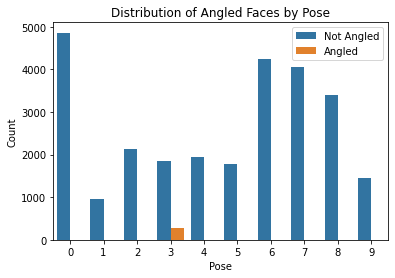

In [12]:
# Plot pose distribution with face_angled hue in seaborn
sns.countplot(x='Pose', hue='face_angled', data=df)
# Add labels
# Edit legend
plt.legend(title='', loc='upper right', labels=['Not Angled', 'Angled'])
plt.title('Distribution of Angled Faces by Pose')
plt.xlabel('Pose')
plt.ylabel('Count')
# Add counts
plt.show()

# Experiments

In [13]:
results = {}
experiment_names = {}

Shape of training data: (8900, 52)
Shape of training labels: (8900,)
F1 score: 0.7236842105263158
Accuracy: 0.7236842105263158


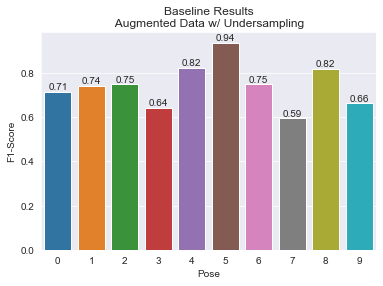

In [105]:
# Name
experiment = 'v1'
experiment_names[experiment] = 'original'

# Design
df_experiment = df.copy()

# Do
y_pred1, y_test1 = y_pred_from_df(df_experiment, std=False, undersample=True, class_weights=False)
print(f"F1 score: {f1_score(y_test1, y_pred1, average='micro')}")
print(f"Accuracy: {accuracy_score(y_test1, y_pred1)}")
plot_class_f1s(y_pred1, y_test1, title='Baseline Results\n Augmented Data w/ Undersampling')
# results[experiment] =  f1_score(y_test, y_pred, average='micro')


F1 score: 0.7258167841127482
Accuracy score: 0.7258167841127482


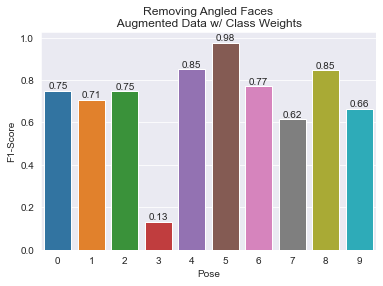

In [107]:
# Design
df_experiment = df.copy()
df_experiment = df_experiment[(df_experiment.face_angled != 1)]

# Do
y_pred, y_test = y_pred_from_df(df_experiment, std=False, undersample=False, class_weights=True)
print(f"F1 score: {f1_score(y_test, y_pred, average='micro')}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title='Removing Angled Faces\n Augmented Data w/ Class Weights')

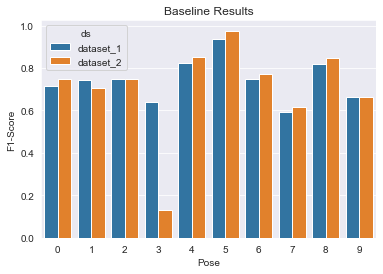

In [108]:
# Comparing with and without angled faces
plot_classes_f1s(y_pred1, y_test1, y_pred, y_test)

### Additional plots of baseline data

In [111]:
from sklearn import metrics
metrics.plot_roc_curve(lr, X_test, y_test)

NameError: name 'X_test' is not defined

Shape of training data: (8900, 52)
Shape of training labels: (8900,)


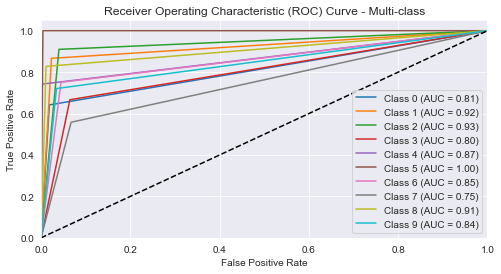

In [98]:
y_pred_from_df(df_experiment, std=False, undersample=True, class_weights=False)
N_CLASSES = 10
y_test_bin = label_binarize(y_test, classes=range(N_CLASSES))
y_pred_bin = label_binarize(y_pred, classes=range(N_CLASSES))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:,i], y_pred_bin[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 4))
for i in range(N_CLASSES):
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(i, roc_auc[i]))

# set plot size
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multi-class')
plt.legend(loc='lower right')
plt.show()

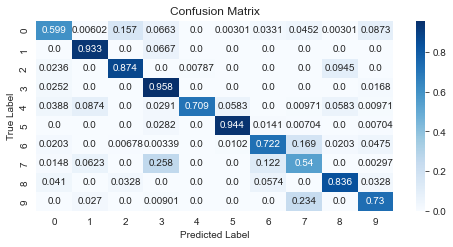

In [100]:
cm = confusion_matrix(y_test1, y_pred1, normalize='true')  # Calculate the percentages in the confusion matrix 
# cm_percent = cm / cm.astype(float).sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 3.5))
sns.heatmap(cm, annot=True, fmt='.3', cmap='Blues')
# set seaborn plot size
# sns.set(rc={'figure.figsize':(8, 6)})
plt.title(f"Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Variations on dataset results

F1 score: 0.727116704805492


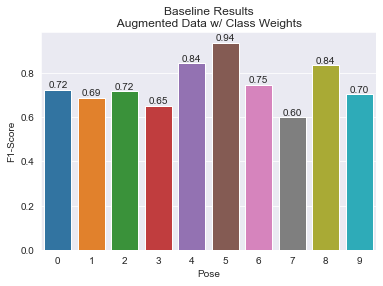

In [103]:
# Name
experiment = 'v2'
# experiment_names[experiment] = 'augmented'

# Design
df_experiment = df.copy()

# Do
y_pred, y_test = y_pred_from_df(df_experiment, std=False, undersample=False, class_weights=True)
print(f"F1 score: {f1_score(y_test, y_pred, average='micro')}")
plot_class_f1s(y_pred, y_test, title='Baseline Results\n Augmented Data w/ Class Weights')
results[experiment] =  f1_score(y_test, y_pred, average='micro')

Shape of training data: (8900, 52)
Shape of training labels: (8900,)
F1 score: 0.7236842105263158


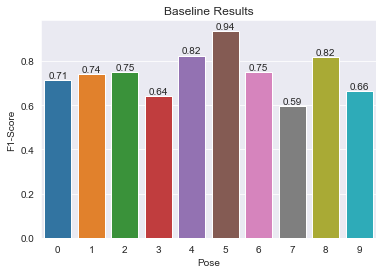

In [28]:
# Name
experiment = 'v3'
experiment_names[experiment] = 'augmented & undersampled'

# Design
df_experiment = df

# Do
y_pred, y_test = y_pred_from_df(df_experiment, std=False, undersample=True, class_weights=False)
print(f"F1 score: {f1_score(y_test, y_pred, average='micro')}")
plot_class_f1s(y_pred, y_test)
results[experiment] =  f1_score(y_test, y_pred, average='micro')

F1 score: 0.727116704805492


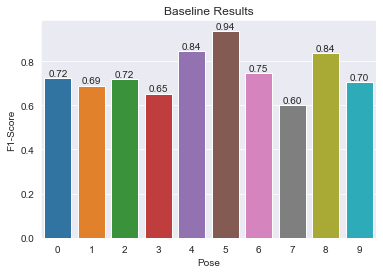

In [29]:
# Name
experiment = 'v4'
experiment_names[experiment] = 'augmented & class_weights'

# Design
df_experiment = df

# Do
y_pred, y_test = y_pred_from_df(df_experiment, std=False, undersample=False, class_weights=True)
print(f"F1 score: {f1_score(y_test, y_pred, average='micro')}")
plot_class_f1s(y_pred, y_test)
results[experiment] =  f1_score(y_test, y_pred, average='micro')

F1 score: 0.727116704805492


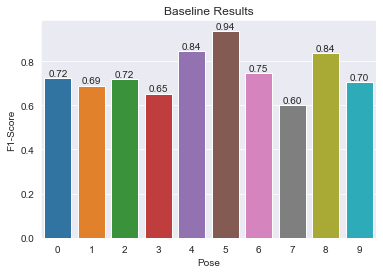

In [46]:
# Name
experiment = 'v5'
experiment_names[experiment] = 'augmented & class_weights & std '

# Design
df_experiment = df.copy()

# Do
y_pred, y_test = y_pred_from_df(df_experiment, std=False, undersample=False, class_weights=True)
print(f"F1 score: {f1_score(y_test, y_pred, average='micro')}")
plot_class_f1s(y_pred, y_test)
results[experiment] =  f1_score(y_test, y_pred, average='micro')

F1 score: 0.7796610169491526


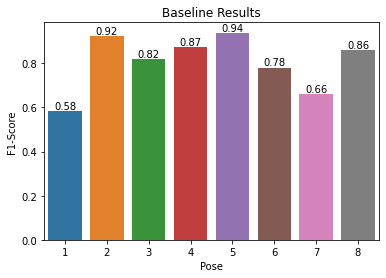

In [ ]:
# Name
experiment = 'v6'
experiment_names[experiment] = 'augmented & class_weights & std & pose9==pose6'

# Design
df_experiment = df.copy()
df_experiment.loc[df_experiment.Pose == 9, 'Pose'] = 6

# Do
y_pred, y_test = y_pred_from_df(df_experiment, std=True, undersample=False, class_weights=True)
print(f"F1 score: {f1_score(y_test, y_pred, average='micro')}")
plot_class_f1s(y_pred, y_test)
results[experiment] =  f1_score(y_test, y_pred, average='micro')

F1 score: 0.768361581920904


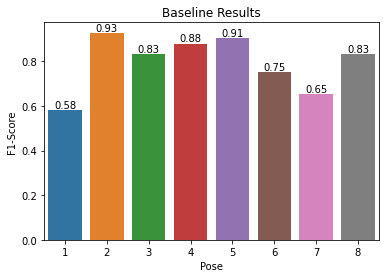

In [ ]:
# Name
experiment = 'v7'
experiment_names[experiment] = 'augmented, class_weights, std, p6==p9, GiF fix'

# Design
df_experiment = df.copy()
df_experiment.loc[(df_experiment.Creator == 'Glowinface') & (df_experiment.Pose == 4), 'Pose'] = 8.0
df_experiment.loc[df_experiment.Pose == 9, 'Pose'] = 6

# Do
y_pred, y_test = y_pred_from_df(df_experiment, std=True, undersample=False, class_weights=True)
print(f"F1 score: {f1_score(y_test, y_pred, average='micro')}")
plot_class_f1s(y_pred, y_test)
results[experiment] =  f1_score(y_test, y_pred, average='micro')

F1 score: 0.7682020802377415


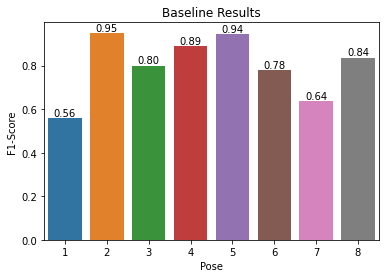

In [ ]:
# Name
experiment = 'v8'
experiment_names[experiment] = 'augmented, class_weights, std, p6==p9, Angled face fix'

# Design
df_experiment = df.copy()
df_experiment.loc[(df_experiment.Creator == 'Glowinface') & (df_experiment.Pose == 4), 'Pose'] = 8.0
df_experiment.loc[df_experiment.Pose == 9, 'Pose'] = 6
df_experiment = df_experiment[df_experiment.poor_quality != 1]
df_experiment = df_experiment[((df_experiment.face_angled != 1) | (df_experiment.Pose == 3))]

# Do
y_pred, y_test = y_pred_from_df(df_experiment, std=True, undersample=False, class_weights=True)
print(f"F1 score: {f1_score(y_test, y_pred, average='micro')}")
plot_class_f1s(y_pred, y_test)
results[experiment] =  f1_score(y_test, y_pred, average='micro')



### Comparing f1-score across models

Text(0, 0.5, 'F1 score')

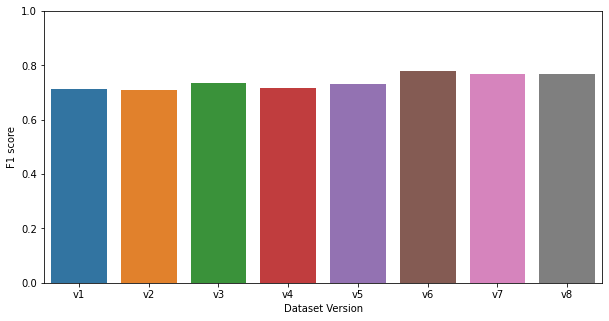

In [ ]:
# Plot results
# plt.figure(figsize=(10, 5))
# plt.bar(experiment_names.keys(), results.values())

# Plot results using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x=list(experiment_names.keys()), y=list(results.values()))
# Set y axis to be in range 0-1
plt.ylim(0, 1)
# Set x title
plt.xlabel('Dataset Version')
# Set y title
plt.ylabel('F1 score')


# Binary Classification Models

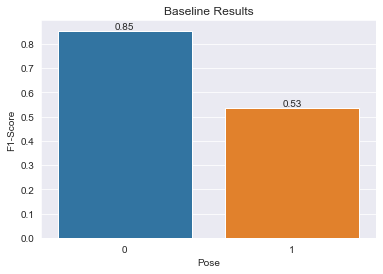

In [110]:
df_pose = df.copy()
key_pose = 7
df_pose.loc[df_pose.Pose != key_pose, 'Pose'] = 0
df_pose.loc[df_pose.Pose == key_pose, 'Pose'] = 1
y_pred_1, y_test_1 = y_pred_from_df(df_pose, std=False, undersample=False, class_weights=True)
plot_class_f1s(y_pred_1, y_test_1)

# Testing new features

## Head Angle

In [14]:
features = get_features(df)
features['head_angle'] = df['head_angle']

X_train = features[~df.Creator.isin(test_creators)]
y_train = df.Pose[~df.Creator.isin(test_creators)]
X_test = features[df.Creator.isin(test_creators)]
y_test = df.Pose[df.Creator.isin(test_creators)]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights = class_weight.compute_class_weight('balanced',
                                                classes = np.unique(y_train),
                                                y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

F1 score: 0.7829736211031175
Accuracy score: 0.7829736211031175


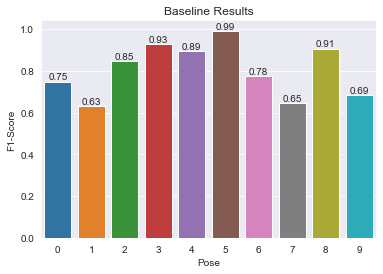

In [15]:
lr = LogisticRegression(class_weight=class_weights, random_state=SEED, max_iter=1000, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred, average='micro')}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test)

## Pose 1 and 9 

In [16]:
df.head()

,Filename,blendshapes,landmarks,Pose,Face Obstructed,Hands on Face,Notes,poor_quality,face_angled,Creator,Gender,Apparent_Race,head_angle,brow_arch,brow_raise_ratio,lid_brow_ratio
0,aug-Pose_2_Face-Yoga-Method_416.jpg,"[7.1687679792376e-07, 0.0015940895536914468, 0...","[(0.5354241728782654, 0.3942164480686188, -0.0...",2,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.005279,0.016992,0.624641,0.600919
1,zoom-Pose_2_Face-Yoga-Method_416.jpg,"[9.191711001221847e-07, 0.0002983348094858229,...","[(0.46912822127342224, 0.2676655948162079, -0....",2,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.009748,0.016792,0.580730,0.721970
2,shear-Pose_2_Face-Yoga-Method_416.jpg,"[4.570634928313666e-07, 0.0008711821283213794,...","[(0.4749401807785034, 0.40972456336021423, -0....",2,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.003687,0.010946,0.595802,0.678410
3,zoom-Pose_2_Face-Yoga-Method_417.jpg,"[1.2624046803466626e-06, 0.0002172658132622018...","[(0.4661442041397095, 0.2637966573238373, -0.0...",2,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.009163,0.016876,0.583923,0.712553
4,flip-Pose_2_Face-Yoga-Method_415.jpg,"[5.646483600685315e-07, 0.0006009486387483776,...","[(0.5249334573745728, 0.3435852825641632, -0.0...",2,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.011169,0.010762,0.598729,0.670204


In [17]:
features = get_features(df)
features['brow_arch'] = df['brow_arch']
features['brow_raise_ratio'] = df['brow_raise_ratio']
features['lid_brow_ratio'] = df['lid_brow_ratio']

X_train = features[~df.Creator.isin(test_creators)]
y_train = df.Pose[~df.Creator.isin(test_creators)]
X_test = features[df.Creator.isin(test_creators)]
y_test = df.Pose[df.Creator.isin(test_creators)]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights = class_weight.compute_class_weight('balanced',
                                                classes = np.unique(y_train),
                                                y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

F1 score: 0.7673860911270983
Accuracy score: 0.7673860911270983


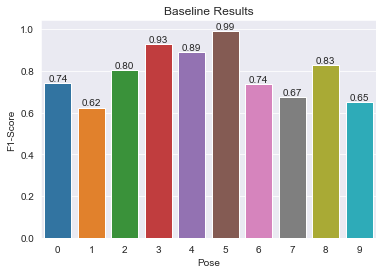

In [18]:
lr = LogisticRegression(class_weight=class_weights, random_state=SEED, max_iter=1000, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred, average='micro')}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test)

# Binary Model Fine Tuning

## Pose 1

In [105]:
df_pose.head()

,Filename,blendshapes,landmarks,Pose,Face Obstructed,Hands on Face,Notes,poor_quality,face_angled,Creator,Gender,Apparent_Race,head_angle,brow_arch,brow_raise_ratio,lid_brow_ratio
0,aug-Pose_2_Face-Yoga-Method_416.jpg,"[7.1687679792376e-07, 0.0015940895536914468, 0...","[(0.5354241728782654, 0.3942164480686188, -0.0...",0,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.005279,0.016992,0.624641,0.600919
1,zoom-Pose_2_Face-Yoga-Method_416.jpg,"[9.191711001221847e-07, 0.0002983348094858229,...","[(0.46912822127342224, 0.2676655948162079, -0....",0,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.009748,0.016792,0.580730,0.721970
2,shear-Pose_2_Face-Yoga-Method_416.jpg,"[4.570634928313666e-07, 0.0008711821283213794,...","[(0.4749401807785034, 0.40972456336021423, -0....",0,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.003687,0.010946,0.595802,0.678410
3,zoom-Pose_2_Face-Yoga-Method_417.jpg,"[1.2624046803466626e-06, 0.0002172658132622018...","[(0.4661442041397095, 0.2637966573238373, -0.0...",0,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.009163,0.016876,0.583923,0.712553
4,flip-Pose_2_Face-Yoga-Method_415.jpg,"[5.646483600685315e-07, 0.0006009486387483776,...","[(0.5249334573745728, 0.3435852825641632, -0.0...",0,0,0,NaN,0,0,Face-Yoga-Method,F,Asian,0.011169,0.010762,0.598729,0.670204


In [137]:
# Set up Data
df_pose = df.copy()
key_pose = 1
df_pose.loc[df_pose.Pose != key_pose, 'Pose'] = 0
df_pose.loc[df_pose.Pose == key_pose, 'Pose'] = 1

features = get_features(df_pose)
features['lid_brow_ratio'] = df['lid_brow_ratio']
features['brow_arch'] = df['brow_arch']
features['brow_raise_ratio'] = df['brow_raise_ratio']

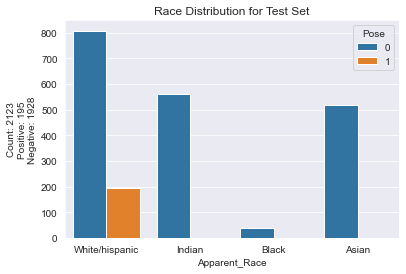

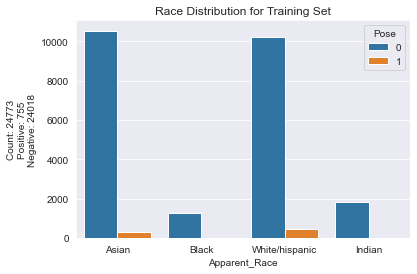

In [138]:
# Custom Test + Training Split
test_creators_p1 = ['Anna-Veronika', 'Blush-with-me-Parmita', 'Doctora-Claudia-Garcia',
                 'Gesund-durchs-Leben', 'Goldbeauty', 'Muscle-Watching-L', 'Natty',
                 'Pilates-by-Lisa', 'Shanthi-Kasiraj', 'Siddhi-yoga-hindi',
                 'templo-del-masaje', 'thefaceyogalab']

test_df = df_pose[df_pose.Creator.isin(test_creators_p1)]
sns.countplot(x='Apparent_Race', data=test_df, hue='Pose')
plt.title('Race Distribution for Test Set')
plt.ylabel(f'Count: {test_df.shape[0]}\n\
Positive: {test_df[test_df.Pose == 1].shape[0]}\n\
Negative: {test_df[test_df.Pose == 0].shape[0]}')
plt.show()

train_df = df_pose[~df_pose.Creator.isin(test_creators_p1)]
sns.countplot(x='Apparent_Race', data=train_df, hue='Pose')
plt.title('Race Distribution for Training Set')
plt.ylabel(f'Count: {train_df.shape[0]}\n\
Positive: {train_df[train_df.Pose == 1].shape[0]}\n\
Negative: {train_df[train_df.Pose == 0].shape[0]}')
plt.show()

In [139]:
# Prepare inputs
X_train = features[~df_pose.Creator.isin(test_creators_p1)]
y_train = df_pose.Pose[~df_pose.Creator.isin(test_creators_p1)]
X_test = features[df_pose.Creator.isin(test_creators_p1)]
y_test = df_pose.Pose[df_pose.Creator.isin(test_creators_p1)]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights = class_weight.compute_class_weight('balanced',
                                                classes = np.unique(y_train),
                                                y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

weights_array = class_weight.compute_sample_weight('balanced', y=y_train)

F1 score: 0.5768421052631578
Accuracy score: 0.9053226566179934


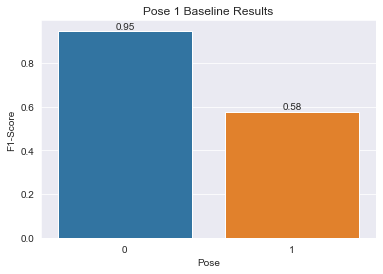

In [140]:
lr = LogisticRegression(class_weight=class_weights, random_state=SEED, max_iter=1000, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title='Pose 1 Baseline Results')

In [ ]:
# Grid search for best hyperparameters
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

best_score = 0
best_grid = None
for g in ParameterGrid(params):
    xgb1.set_params(**g)
    xgb1.fit(X_train, y_train, sample_weight=weights_array)
    y_pred = xgb1.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f1)
    if f1 > best_score:
        best_score = f1
        best_grid = g

In [135]:
print(best_score)
print(best_grid)

0.8103448275862069
{'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 1.0}


F1 score: 0.8103448275862069
Accuracy score: 0.9689119170984456


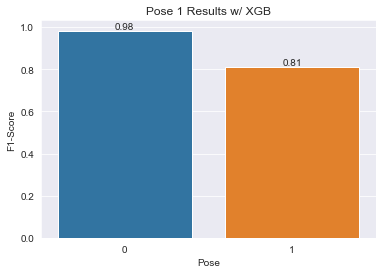

In [141]:
xgb1 = xgb.XGBClassifier(seed=SEED)
xgb1.set_params(**best_grid)
xgb1.fit(X_train, y_train, sample_weight=weights_array)
y_pred = xgb1.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title='Pose 1 Results w/ XGB')

## Pose 2

In [143]:
# Set up Data
df_pose = df.copy()
key_pose = 2
df_pose.loc[df_pose.Pose != key_pose, 'Pose'] = 0
df_pose.loc[df_pose.Pose == key_pose, 'Pose'] = 1

features = get_features(df_pose)

In [145]:
df_pose[df_pose.Pose == 1].Creator.value_counts()

Fit-Eagles               860
AVA-LEE                  450
Adam-Fields-DC           360
Face-Yoga-Method         210
Accents-Way-English      130
Blush-with-me-Parmita    111
Name: Creator, dtype: int64

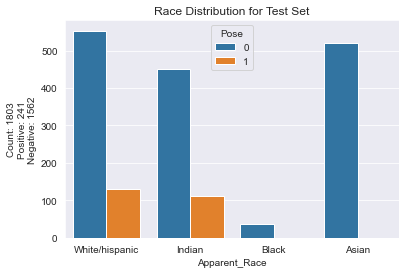

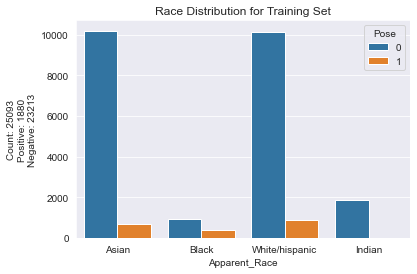

In [150]:
# Check Test + Training Split
test_creators_p2 = ['Anna-Veronika', 'Blush-with-me-Parmita', 'Doctora-Claudia-Garcia',
                 'Gesund-durchs-Leben', 'Goldbeauty', 'Muscle-Watching-L', 'Natty',
                 'Pilates-by-Lisa', 'Shanthi-Kasiraj', 'Siddhi-yoga-hindi',
                 'templo-del-masaje', 'Accents-Way-English']

test_df = df_pose[df_pose.Creator.isin(test_creators_p2)]
sns.countplot(x='Apparent_Race', data=test_df, hue='Pose')
plt.title('Race Distribution for Test Set')
plt.ylabel(f'Count: {test_df.shape[0]}\n\
Positive: {test_df[test_df.Pose == 1].shape[0]}\n\
Negative: {test_df[test_df.Pose == 0].shape[0]}')
plt.show()

train_df = df_pose[~df_pose.Creator.isin(test_creators_p2)]
sns.countplot(x='Apparent_Race', data=train_df, hue='Pose')
plt.title('Race Distribution for Training Set')
plt.ylabel(f'Count: {train_df.shape[0]}\n\
Positive: {train_df[train_df.Pose == 1].shape[0]}\n\
Negative: {train_df[train_df.Pose == 0].shape[0]}')
plt.show()

In [153]:
# Prepare inputs
X_train = features[~df_pose.Creator.isin(test_creators_p2)]
y_train = df_pose.Pose[~df_pose.Creator.isin(test_creators_p2)]
X_test = features[df_pose.Creator.isin(test_creators_p2)]
y_test = df_pose.Pose[df_pose.Creator.isin(test_creators_p2)]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights = class_weight.compute_class_weight('balanced',
                                                classes = np.unique(y_train),
                                                y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

weights_array = class_weight.compute_sample_weight('balanced', y=y_train)

F1 score: 0.6804123711340206
Accuracy score: 0.9140321686078757


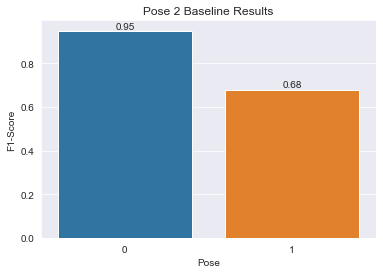

In [152]:
lr = LogisticRegression(class_weight=class_weights, random_state=SEED, max_iter=1000, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title='Pose 2 Baseline Results')

In [160]:
# Set params to grid search for ExtraTreesClassifier
params = {
        'n_estimators': [300, 400, 500],
        'max_depth': [5, 20, 35],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 3, 5]
        }

best_score = 0
best_grid = None
i = 0
for g in ParameterGrid(params):
    i += 1
    et2.set_params(**g)
    et2.fit(X_train, y_train, sample_weight=weights_array)
    y_pred = et2.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(i, f1, g)
    if f1 > best_score:
        best_score = f1
        best_grid = g


1 0.6298507462686567 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
2 0.626865671641791 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
3 0.626865671641791 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
4 0.6216216216216217 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
5 0.6289120715350223 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}
6 0.624813153961136 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500}
7 0.6236881559220391 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 300}
8 0.6289120715350223 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 400}
9 0.624813153961136 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}
10 0.6236881559220391 {'max_depth': 5, 'min_sample

In [161]:
print(best_score)
print(best_grid)

0.7767441860465117
{'max_depth': 35, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500}


F1 score: 0.7767441860465117
Accuracy score: 0.9467554076539102


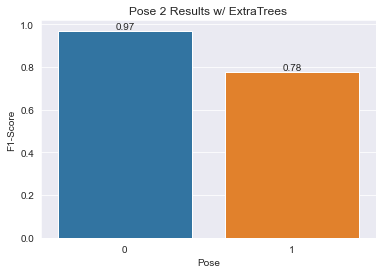

In [162]:
et2 = ExtraTreesClassifier(random_state=SEED)
et2.set_params(**best_grid)
et2.fit(X_train, y_train, sample_weight=weights_array)
y_pred = et2.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title='Pose 2 Results w/ ExtraTrees')

## Pose 3

In [168]:
# Set up Data
df_pose = df.copy()
key_pose = 3
df_pose.loc[df_pose.Pose != key_pose, 'Pose'] = 0
df_pose.loc[df_pose.Pose == key_pose, 'Pose'] = 1

features = get_features(df_pose)
features['head_angle'] = df['head_angle']


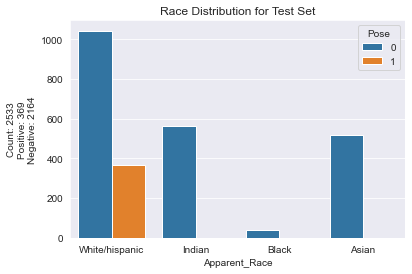

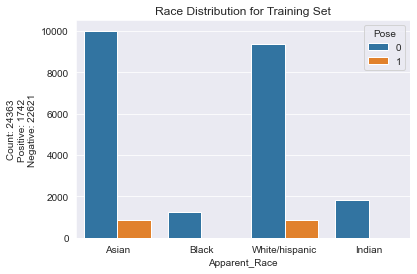

In [193]:
# Custom Test + Training Split
test_creators_p3 = test_creators + ['Sientete-Bien']

test_df = df_pose[df_pose.Creator.isin(test_creators_p3)]
sns.countplot(x='Apparent_Race', data=test_df, hue='Pose')
plt.title('Race Distribution for Test Set')
plt.ylabel(f'Count: {test_df.shape[0]}\n\
Positive: {test_df[test_df.Pose == 1].shape[0]}\n\
Negative: {test_df[test_df.Pose == 0].shape[0]}')
plt.show()

train_df = df_pose[~df_pose.Creator.isin(test_creators_p3)]
sns.countplot(x='Apparent_Race', data=train_df, hue='Pose')
plt.title('Race Distribution for Training Set')
plt.ylabel(f'Count: {train_df.shape[0]}\n\
Positive: {train_df[train_df.Pose == 1].shape[0]}\n\
Negative: {train_df[train_df.Pose == 0].shape[0]}')
plt.show()

In [194]:
# Prepare inputs
X_train = features[~df_pose.Creator.isin(test_creators_p3)]
y_train = df_pose.Pose[~df_pose.Creator.isin(test_creators_p3)]
X_test = features[df_pose.Creator.isin(test_creators_p3)]
y_test = df_pose.Pose[df_pose.Creator.isin(test_creators_p3)]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights = class_weight.compute_class_weight('balanced',
                                                classes = np.unique(y_train),
                                                y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

weights_array = class_weight.compute_sample_weight('balanced', y=y_train)

F1 score: 0.8923076923076922
Accuracy score: 0.9844703272323905


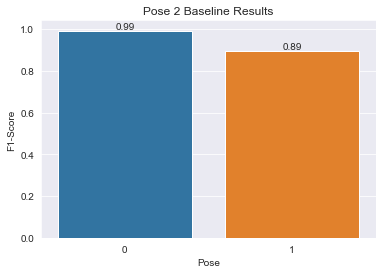

In [195]:
lr = LogisticRegression(class_weight=class_weights, random_state=SEED, max_iter=1000, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title='Pose 2 Baseline Results')

In [198]:
# Grid search for best hyperparameters
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 2.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 6, 10]
        }

best_score = 0
best_grid = None
i = 0
for g in ParameterGrid(params):
    i += 1
    xgb1.set_params(**g)
    xgb1.fit(X_train, y_train, sample_weight=weights_array)
    y_pred = xgb1.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(i, f1, g)
    if f1 > best_score:
        best_score = f1
        best_grid = g

1 0.9658119658119659 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
2 0.9661016949152542 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}
3 0.9658119658119659 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
4 0.9661016949152542 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6}
5 0.9661016949152542 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8}
6 0.9658119658119659 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}
7 0.9527896995708156 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6}
8 0.970464135021097 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.8}
9 0.9743589743589743 {'colsample_bytree': 0.6, 'gamma': 0

In [199]:
print(best_score)
print(best_grid)

0.983050847457627
{'colsample_bytree': 0.6, 'gamma': 2.5, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 1.0}


F1 score: 0.983050847457627
Accuracy score: 0.9977814753189129


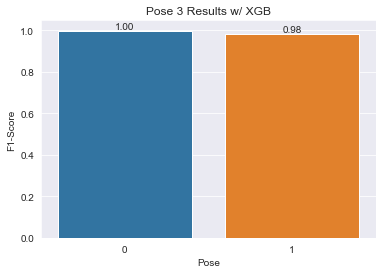

In [201]:
xgb3 = xgb.XGBClassifier(seed=SEED)
xgb3.set_params(**best_grid)
xgb3.fit(X_train, y_train, sample_weight=weights_array)
y_pred = xgb3.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title=f'Pose {key_pose} Results w/ XGB')

## Pose 4

In [202]:
# Set up Data
df_pose = df.copy()
key_pose = 4
df_pose.loc[df_pose.Pose != key_pose, 'Pose'] = 0
df_pose.loc[df_pose.Pose == key_pose, 'Pose'] = 1

features = get_features(df_pose)

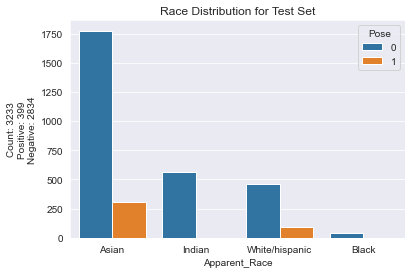

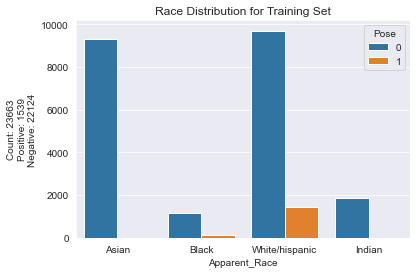

In [215]:
# Custom Test + Training Split
test_creators_p4 = test_creators + ['Masumi-Channel']

test_df = df_pose[df_pose.Creator.isin(test_creators_p4)]
sns.countplot(x='Apparent_Race', data=test_df, hue='Pose')
plt.title('Race Distribution for Test Set')
plt.ylabel(f'Count: {test_df.shape[0]}\n\
Positive: {test_df[test_df.Pose == 1].shape[0]}\n\
Negative: {test_df[test_df.Pose == 0].shape[0]}')
plt.show()

train_df = df_pose[~df_pose.Creator.isin(test_creators_p4)]
sns.countplot(x='Apparent_Race', data=train_df, hue='Pose')
plt.title('Race Distribution for Training Set')
plt.ylabel(f'Count: {train_df.shape[0]}\n\
Positive: {train_df[train_df.Pose == 1].shape[0]}\n\
Negative: {train_df[train_df.Pose == 0].shape[0]}')
plt.show()

In [216]:
print(train_df[train_df.Pose == 1].Creator.value_counts())
print(test_df[test_df.Pose == 1].Creator.value_counts())

Yoga-Face           560
Face-Yoga-Expert    314
FacialUP!           280
Glowinface          130
Khichi-Beauty       120
thefaceyogalab       80
The-Uma-Show         55
Name: Creator, dtype: int64
Masumi-Channel     310
Pilates-by-Lisa     89
Name: Creator, dtype: int64


In [217]:
# Prepare inputs
X_train = features[~df_pose.Creator.isin(test_creators_p4)]
y_train = df_pose.Pose[~df_pose.Creator.isin(test_creators_p4)]
X_test = features[df_pose.Creator.isin(test_creators_p4)]
y_test = df_pose.Pose[df_pose.Creator.isin(test_creators_p4)]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights = class_weight.compute_class_weight('balanced',
                                                classes = np.unique(y_train),
                                                y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

weights_array = class_weight.compute_sample_weight('balanced', y=y_train)

F1 score: 0.8191126279863481
Accuracy score: 0.9508196721311475


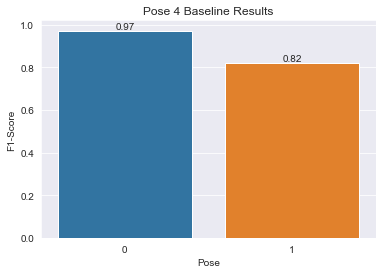

In [218]:
lr = LogisticRegression(class_weight=class_weights, random_state=SEED, max_iter=1000, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title=f'Pose {key_pose} Baseline Results')

In [219]:
# Grid search for best hyperparameters
# Set params to grid search for ExtraTreesClassifier
params = {
        'n_estimators': [300, 400, 500],
        'max_depth': [5, 20, 35],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 3, 5]
        }

et4 = ExtraTreesClassifier(random_state=SEED)
best_score = 0
best_grid = None
i = 0
for g in ParameterGrid(params):
    i += 1
    et4.set_params(**g)
    et4.fit(X_train, y_train, sample_weight=weights_array)
    y_pred = et4.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(i, f1, g)
    if f1 > best_score:
        best_score = f1
        best_grid = g

1 0.9674185463659147 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
2 0.9722921914357683 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
3 0.9697732997481108 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
4 0.9686323713927227 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
5 0.971069182389937 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}
6 0.9697732997481108 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500}
7 0.9686323713927227 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 300}
8 0.9722921914357683 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 400}
9 0.9697732997481108 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}
10 0.971069182389937 {'max_depth': 5, 'min_samp

In [221]:
print(best_score)
print(best_grid)

0.9735182849936949
{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 400}


F1 score: 0.9735182849936949
Accuracy score: 0.9935044849984535


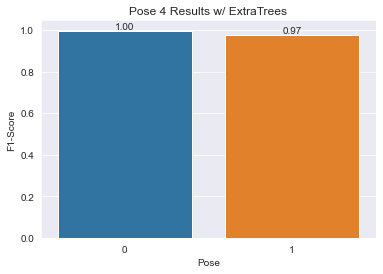

In [222]:
et4 = ExtraTreesClassifier(random_state=SEED)
et4.set_params(**best_grid)
et4.fit(X_train, y_train, sample_weight=weights_array)
y_pred = et4.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title=f'Pose {key_pose} Results w/ ExtraTrees')

## Pose 5

In [223]:
# Set up pose data
df_pose = df.copy()
key_pose = 5
df_pose.loc[df_pose.Pose != key_pose, 'Pose'] = 0
df_pose.loc[df_pose.Pose == key_pose, 'Pose'] = 1

features = get_features(df_pose)

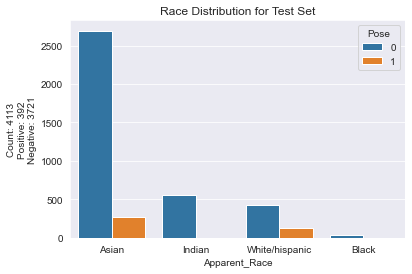

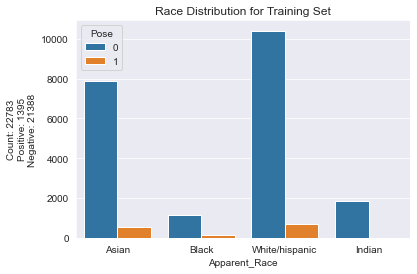

In [230]:
# Custom Test + Training Split
test_creators_p5 = test_creators + ['HisDream']

test_df = df_pose[df_pose.Creator.isin(test_creators_p5)]
sns.countplot(x='Apparent_Race', data=test_df, hue='Pose')
plt.title('Race Distribution for Test Set')
plt.ylabel(f'Count: {test_df.shape[0]}\n\
Positive: {test_df[test_df.Pose == 1].shape[0]}\n\
Negative: {test_df[test_df.Pose == 0].shape[0]}')
plt.show()

train_df = df_pose[~df_pose.Creator.isin(test_creators_p5)]
sns.countplot(x='Apparent_Race', data=train_df, hue='Pose')
plt.title('Race Distribution for Training Set')
plt.ylabel(f'Count: {train_df.shape[0]}\n\
Positive: {train_df[train_df.Pose == 1].shape[0]}\n\
Negative: {train_df[train_df.Pose == 0].shape[0]}')
plt.show()

In [231]:
print(train_df[train_df.Pose == 1].Creator.value_counts())
print(test_df[test_df.Pose == 1].Creator.value_counts())

Yoga-Face         345
Masumi-Channel    315
FacialUP!         310
AVA-LEE           230
Khichi-Beauty     145
The-Uma-Show       50
Name: Creator, dtype: int64
HisDream           270
Pilates-by-Lisa    113
Anna-Veronika        9
Name: Creator, dtype: int64


In [232]:
# Prepare inputs
X_train = features[~df_pose.Creator.isin(test_creators_p5)]
y_train = df_pose.Pose[~df_pose.Creator.isin(test_creators_p5)]
X_test = features[df_pose.Creator.isin(test_creators_p5)]
y_test = df_pose.Pose[df_pose.Creator.isin(test_creators_p5)]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights = class_weight.compute_class_weight('balanced',
                                                classes = np.unique(y_train),
                                                y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

weights_array = class_weight.compute_sample_weight('balanced', y=y_train)

F1 score: 0.9400244798041615
Accuracy score: 0.9880865548261609


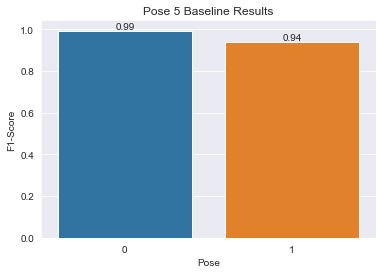

In [233]:
lr = LogisticRegression(class_weight=class_weights, random_state=SEED, max_iter=1000, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title=f'Pose {key_pose} Baseline Results')

In [234]:
# Grid search for best hyperparameters
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.5, 2.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 6, 10]
        }

best_score = 0
best_grid = None
i = 0
for g in ParameterGrid(params):
    i += 1
    xgb1.set_params(**g)
    xgb1.fit(X_train, y_train, sample_weight=weights_array)
    y_pred = xgb1.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(i, f1, g)
    if f1 > best_score:
        best_score = f1
        best_grid = g

1 0.949935815147625 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
2 0.9736511919698871 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}
3 0.9487179487179488 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
4 0.9324675324675324 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6}
5 0.9553001277139208 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8}
6 0.9527458492975734 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}
7 0.9666666666666668 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6}
8 0.9619289340101522 {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.8}
9 0.9602053915275995 {'colsample_bytree': 0.6, 'gamma': 0

In [235]:
print(best_score)
print(best_grid)

0.986093552465234
{'colsample_bytree': 1.0, 'gamma': 2.5, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 1.0}


F1 score: 0.986093552465234
Accuracy score: 0.9973255531242402


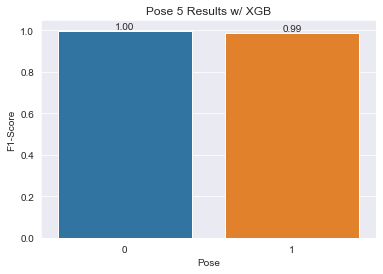

In [236]:
xgb5 = xgb.XGBClassifier(seed=SEED)
xgb5.set_params(**best_grid)
xgb5.fit(X_train, y_train, sample_weight=weights_array)
y_pred = xgb5.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title=f'Pose {key_pose} Results w/ XGB')

## Pose 6 - Extra Trees

In [15]:
# Set up Data
df_pose = df.copy()
key_pose = 6
df_pose.loc[df_pose.Pose != key_pose, 'Pose'] = 0
df_pose.loc[df_pose.Pose == key_pose, 'Pose'] = 1

features = get_features(df_pose)

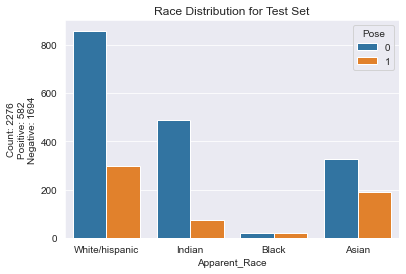

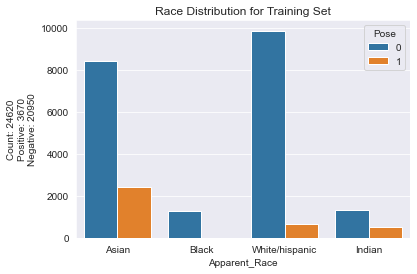

In [25]:
# Custom Test + Training Split
test_creators_p6 = test_creators + ['Funfitt-with-Susana-Yabar', 'Daniela-Suarez']

test_df = df_pose[df_pose.Creator.isin(test_creators_p6)]
sns.countplot(x='Apparent_Race', data=test_df, hue='Pose')
plt.title('Race Distribution for Test Set')
plt.ylabel(f'Count: {test_df.shape[0]}\n\
Positive: {test_df[test_df.Pose == 1].shape[0]}\n\
Negative: {test_df[test_df.Pose == 0].shape[0]}')
plt.show()

train_df = df_pose[~df_pose.Creator.isin(test_creators_p6)]
sns.countplot(x='Apparent_Race', data=train_df, hue='Pose')
plt.title('Race Distribution for Training Set')
plt.ylabel(f'Count: {train_df.shape[0]}\n\
Positive: {train_df[train_df.Pose == 1].shape[0]}\n\
Negative: {train_df[train_df.Pose == 0].shape[0]}')
plt.show()

In [26]:
print(train_df[train_df.Pose == 1].Creator.value_counts())
print(train_df[train_df.Pose == 1].shape[0])
print(test_df[test_df.Pose == 1].Creator.value_counts())
print(test_df[test_df.Pose == 1].shape[0])

Muscle-Watching-R          885
Masumi-Channel             625
HisDream                   495
Ergotopia                  440
Yoga-with-Souvik           375
isaac-yiu                  280
AVA-LEE                    135
Shraddhas-Tapperz-Dance     95
Brett-Maverick              90
IBC-Mangai                  75
Lakshya-Junction            65
Sientete-Bien               50
NIVEA-espana                35
Facial-Yoga-Plan            20
thefaceyogalab               5
Name: Creator, dtype: int64
3670
Muscle-Watching-L            192
Funfitt-with-Susana-Yabar    170
Daniela-Suarez               127
Shanthi-Kasiraj               45
Gesund-durchs-Leben           18
Siddhi-yoga-hindi             15
Blush-with-me-Parmita         15
Name: Creator, dtype: int64
582


In [27]:
# Prepare inputs
X_train = features[~df_pose.Creator.isin(test_creators_p6)]
y_train = df_pose.Pose[~df_pose.Creator.isin(test_creators_p6)]
X_test = features[df_pose.Creator.isin(test_creators_p6)]
y_test = df_pose.Pose[df_pose.Creator.isin(test_creators_p6)]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights = class_weight.compute_class_weight('balanced',
                                                classes = np.unique(y_train),
                                                y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

weights_array = class_weight.compute_sample_weight('balanced', y=y_train)

F1 score: 0.8668242710795901
Accuracy score: 0.9257469244288224


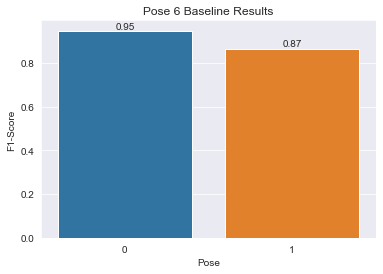

In [28]:
lr = LogisticRegression(class_weight=class_weights, random_state=SEED, max_iter=1000, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title=f'Pose {key_pose} Baseline Results')

In [29]:
# Grid search for best hyperparameters
# Set params to grid search for ExtraTreesClassifier
params = {
        'n_estimators': [300, 400, 500],
        'max_depth': [5, 20, 35],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 3, 5]
        }

et6 = ExtraTreesClassifier(random_state=SEED)
best_score = 0
best_grid = None
i = 0
for g in ParameterGrid(params):
    i += 1
    et6.set_params(**g)
    et6.fit(X_train, y_train, sample_weight=weights_array)
    y_pred = et6.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(i, f1, g)
    if f1 > best_score:
        best_score = f1
        best_grid = g

1 0.8598130841121494 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
2 0.8645262333594361 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
3 0.868131868131868 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
4 0.8598130841121494 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
5 0.8652037617554859 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}
6 0.868131868131868 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500}
7 0.8611544461778471 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 300}
8 0.8658823529411765 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 400}
9 0.8688138256087982 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}
10 0.8604832424006235 {'max_depth': 5, 'min_samp

In [30]:
print(best_score)
print(best_grid)

0.8908450704225351
{'max_depth': 35, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}


F1 score: 0.8908450704225351
Accuracy score: 0.945518453427065


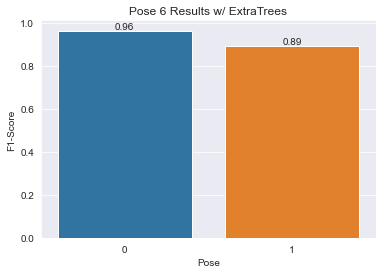

In [31]:
et6 = ExtraTreesClassifier(random_state=SEED)
et6.set_params(**best_grid)
et6.fit(X_train, y_train, sample_weight=weights_array)
y_pred = et6.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title=f'Pose {key_pose} Results w/ ExtraTrees')

## Pose 7

In [47]:
# Set up Data
df_pose = df.copy()
key_pose = 7
df_pose.loc[df_pose.Pose != key_pose, 'Pose'] = 0
df_pose.loc[df_pose.Pose == key_pose, 'Pose'] = 1

features = get_features(df_pose)

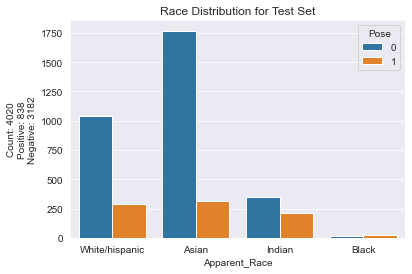

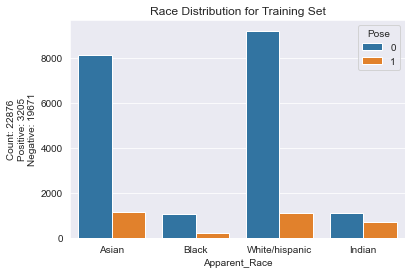

In [61]:
# Custom Test + Training Split
test_creators_p7 = test_creators + ['Masumi-Channel', 'Verena-Boix']

test_df = df_pose[df_pose.Creator.isin(test_creators_p7)]
sns.countplot(x='Apparent_Race', data=test_df, hue='Pose')
plt.title('Race Distribution for Test Set')
plt.ylabel(f'Count: {test_df.shape[0]}\n\
Positive: {test_df[test_df.Pose == 1].shape[0]}\n\
Negative: {test_df[test_df.Pose == 0].shape[0]}')
plt.show()

train_df = df_pose[~df_pose.Creator.isin(test_creators_p7)]
sns.countplot(x='Apparent_Race', data=train_df, hue='Pose')
plt.title('Race Distribution for Training Set')
plt.ylabel(f'Count: {train_df.shape[0]}\n\
Positive: {train_df[train_df.Pose == 1].shape[0]}\n\
Negative: {train_df[train_df.Pose == 0].shape[0]}')
plt.show()

In [62]:
print(train_df[train_df.Pose == 1].Creator.value_counts())
print(train_df[train_df.Pose == 1].shape[0])
print(test_df[test_df.Pose == 1].Creator.value_counts())
print(test_df[test_df.Pose == 1].shape[0])

Instituto-Yvette-pons      630
HisDream                   585
Shraddhas-Tapperz-Dance    325
AVA-LEE                    290
TrabajaTuCuerpo            275
IBC-Mangai-R               220
Yoga-Face                  210
Gabriela-Litschi           200
MIZI                       200
IBC-Mangai-L               170
Face-Up                     70
IBC-Mangai                  30
Name: Creator, dtype: int64
3205
Masumi-Channel            315
Verena-Boix               195
Blush-with-me-Parmita     103
Anna-Veronika              69
Goldbeauty                 63
Siddhi-yoga-hindi          45
Doctora-Claudia-Garcia     28
Gesund-durchs-Leben        20
Name: Creator, dtype: int64
838


In [63]:
# Prepare inputs
X_train = features[~df_pose.Creator.isin(test_creators_p7)]
y_train = df_pose.Pose[~df_pose.Creator.isin(test_creators_p7)]
X_test = features[df_pose.Creator.isin(test_creators_p7)]
y_test = df_pose.Pose[df_pose.Creator.isin(test_creators_p7)]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights = class_weight.compute_class_weight('balanced',
                                                classes = np.unique(y_train),
                                                y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

weights_array = class_weight.compute_sample_weight('balanced', y=y_train)

F1 score: 0.6494281452013924
Accuracy score: 0.8246268656716418


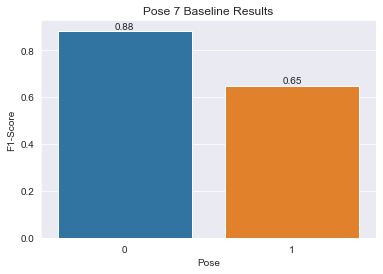

In [64]:
lr = LogisticRegression(class_weight=class_weights, random_state=SEED, max_iter=1000, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title=f'Pose {key_pose} Baseline Results')

In [65]:
# Grid search for best hyperparameters
# Set params to grid search for ExtraTreesClassifier
params = {
        'n_estimators': [300, 400, 500],
        'max_depth': [5, 20, 35],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 3, 5]
        }

et7 = ExtraTreesClassifier(random_state=SEED)
best_score = 0
best_grid = None
i = 0
for g in ParameterGrid(params):
    i += 1
    et7.set_params(**g)
    et7.fit(X_train, y_train, sample_weight=weights_array)
    y_pred = et7.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(i, f1, g)
    if f1 > best_score:
        best_score = f1
        best_grid = g

1 0.5459352280237938 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
2 0.5396929108134596 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
3 0.530729833546735 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
4 0.5461157024793388 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
5 0.5384615384615384 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}
6 0.5303902751119642 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500}
7 0.5464770095931194 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 300}
8 0.5388127853881278 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 400}
9 0.5298817513582614 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}
10 0.5455746367239102 {'max_depth': 5, 'min_sam

In [66]:
print(best_score)
print(best_grid)

0.7246537396121885
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}


F1 score: 0.7246537396121885
Accuracy score: 0.8763681592039801


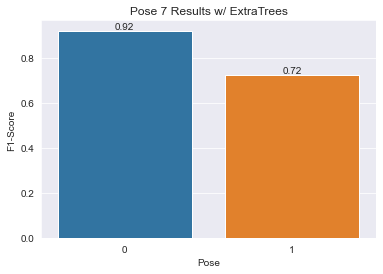

In [67]:
et7 = ExtraTreesClassifier(random_state=SEED)
et7.set_params(**best_grid)
et7.fit(X_train, y_train, sample_weight=weights_array)
y_pred = et7.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title=f'Pose {key_pose} Results w/ ExtraTrees')

## Pose 8 - ExtraTrees

In [68]:
# Set up Data
df_pose = df.copy()
key_pose = 8
df_pose.loc[df_pose.Pose != key_pose, 'Pose'] = 0
df_pose.loc[df_pose.Pose == key_pose, 'Pose'] = 1

features = get_features(df_pose)

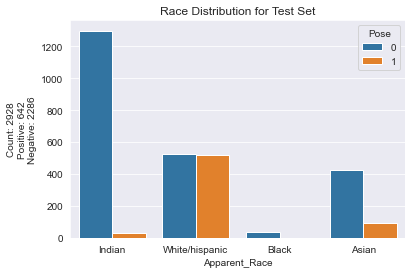

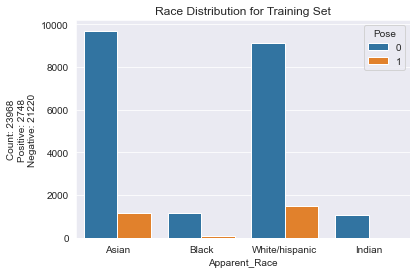

In [79]:
# Custom Test + Training Split
test_creators_p8 = test_creators + ['Valentina-Sadak', 'Yoga-with-Souvik']

test_df = df_pose[df_pose.Creator.isin(test_creators_p8)]
sns.countplot(x='Apparent_Race', data=test_df, hue='Pose')
plt.title('Race Distribution for Test Set')
plt.ylabel(f'Count: {test_df.shape[0]}\n\
Positive: {test_df[test_df.Pose == 1].shape[0]}\n\
Negative: {test_df[test_df.Pose == 0].shape[0]}')
plt.show()

train_df = df_pose[~df_pose.Creator.isin(test_creators_p8)]
sns.countplot(x='Apparent_Race', data=train_df, hue='Pose')
plt.title('Race Distribution for Training Set')
plt.ylabel(f'Count: {train_df.shape[0]}\n\
Positive: {train_df[train_df.Pose == 1].shape[0]}\n\
Negative: {train_df[train_df.Pose == 0].shape[0]}')
plt.show()

In [80]:
print(df_pose[df_pose.Pose == 1].shape[0])
print(train_df[train_df.Pose == 1].Creator.value_counts())
print(train_df[train_df.Pose == 1].shape[0])
print(test_df[test_df.Pose == 1].Creator.value_counts())
print(test_df[test_df.Pose == 1].shape[0])

3390
Muscle-Watching-R            540
Sientete-Bien                425
HisDream                     420
thefaceyogalab               195
Ergotopia                    165
Facial-Yoga-Plan             155
Club-marea-oficial           155
The-Uma-Show                 110
AVA-LEE                      110
Funfitt-with-Susana-Yabar     98
Khichi-Beauty                 95
Brian-Abelson                 95
En-Casa-Contigo               90
Face-Yoga-Method              85
TrabajaTuCuerpo                5
isaac-yiu                      5
Name: Creator, dtype: int64
2748
Valentina-Sadak      495
Muscle-Watching-L     95
Yoga-with-Souvik      25
Natty                 22
Siddhi-yoga-hindi      5
Name: Creator, dtype: int64
642


In [81]:
# Prepare inputs
X_train = features[~df_pose.Creator.isin(test_creators_p8)]
y_train = df_pose.Pose[~df_pose.Creator.isin(test_creators_p8)]
X_test = features[df_pose.Creator.isin(test_creators_p8)]
y_test = df_pose.Pose[df_pose.Creator.isin(test_creators_p8)]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights = class_weight.compute_class_weight('balanced',
                                                classes = np.unique(y_train),
                                                y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

weights_array = class_weight.compute_sample_weight('balanced', y=y_train)

F1 score: 0.9242089771891095
Accuracy score: 0.9648224043715847


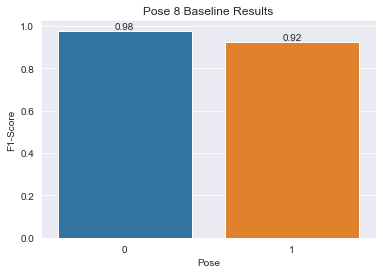

In [82]:
lr = LogisticRegression(class_weight=class_weights, random_state=SEED, max_iter=1000, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title=f'Pose {key_pose} Baseline Results')

In [84]:
# Grid search for best hyperparameters
# Set params to grid search for ExtraTreesClassifier
params = {
        'n_estimators': [300, 400, 500],
        'max_depth': [5, 20, 35],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 3, 5]
        }

et8 = ExtraTreesClassifier(random_state=SEED)
best_score = 0
best_grid = None
i = 0
for g in ParameterGrid(params):
    i += 1
    et8.set_params(**g)
    et8.fit(X_train, y_train, sample_weight=weights_array)
    y_pred = et8.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(i, f1, g)
    if f1 > best_score:
        best_score = f1
        best_grid = g

1 0.9146608315098469 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
2 0.9159970781592404 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
3 0.9194729136163982 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
4 0.9146608315098469 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
5 0.9180087847730601 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400}
6 0.9221732745961821 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500}
7 0.9166666666666666 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 300}
8 0.9166666666666666 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 400}
9 0.9201465201465202 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}
10 0.9153284671532848 {'max_depth': 5, 'min_sa

In [85]:
print(best_score)
print(best_grid)

0.9636650868878356
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500}


F1 score: 0.9636650868878356
Accuracy score: 0.9842896174863388


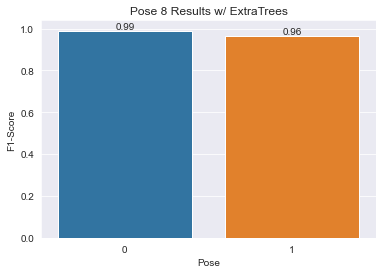

In [87]:
et8.set_params(**best_grid)
et8.fit(X_train, y_train, sample_weight=weights_array)
y_pred = et8.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title=f'Pose {key_pose} Results w/ ExtraTrees')

## Pose 1 - fixed

In [282]:
# Drop creators doing the alternate pose

pose_1_press = ['HisDream', 'Face-Yoga-Expert']
# HisDream - pushing down
# Face-Yoga-Expert - just holding forehead
df_pose = df[~((df.Creator.isin(pose_1_press)) & (df.Pose == 1))]

In [283]:
# Set up Data
key_pose = 1
df_pose.loc[df_pose.Pose != key_pose, 'Pose'] = 0
df_pose.loc[df_pose.Pose == key_pose, 'Pose'] = 1

features = get_features(df_pose)

features['lid_brow_ratio'] = df_pose['lid_brow_ratio']
features['brow_arch'] = df_pose['brow_arch']
features['brow_raise_ratio'] = df_pose['brow_raise_ratio']

/Users/kelianneheinz/opt/anaconda3/envs/myvenv/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


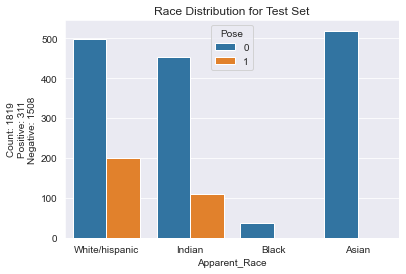

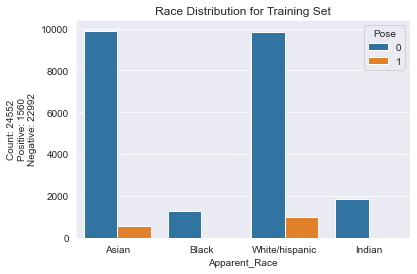

In [284]:
# Custom Test + Training Split
test_creators_p9 = test_creators + ['LibertadDigital']

test_df = df_pose[df_pose.Creator.isin(test_creators_p9)]
sns.countplot(x='Apparent_Race', data=test_df, hue='Pose')
plt.title('Race Distribution for Test Set')
plt.ylabel(f'Count: {test_df.shape[0]}\n\
Positive: {test_df[test_df.Pose == 1].shape[0]}\n\
Negative: {test_df[test_df.Pose == 0].shape[0]}')
plt.show()

train_df = df_pose[~df_pose.Creator.isin(test_creators_p9)]
sns.countplot(x='Apparent_Race', data=train_df, hue='Pose')
plt.title('Race Distribution for Training Set')
plt.ylabel(f'Count: {train_df.shape[0]}\n\
Positive: {train_df[train_df.Pose == 1].shape[0]}\n\
Negative: {train_df[train_df.Pose == 0].shape[0]}')
plt.show()

In [285]:
print(df_pose[df_pose.Pose == 1].shape[0])
print(train_df[train_df.Pose == 1].Creator.value_counts())
print(train_df[train_df.Pose == 1].shape[0])
print(test_df[test_df.Pose == 1].Creator.value_counts())
print(test_df[test_df.Pose == 1].shape[0])

1871
Verena-Boix         475
Face-Yoga-Method    315
AVA-LEE             260
FACEROBICS          225
thefaceyogalab      135
The-Uma-Show         75
isasaweis            75
Name: Creator, dtype: int64
1560
LibertadDigital    140
Goldbeauty         111
Pilates-by-Lisa     60
Name: Creator, dtype: int64
311


In [286]:
# Prepare inputs
X_train = features[~df_pose.Creator.isin(test_creators_p9)]
y_train = df_pose.Pose[~df_pose.Creator.isin(test_creators_p9)]
X_test = features[df_pose.Creator.isin(test_creators_p9)]
y_test = df_pose.Pose[df_pose.Creator.isin(test_creators_p9)]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class_weights = class_weight.compute_class_weight('balanced',
                                                classes = np.unique(y_train),
                                                y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

weights_array = class_weight.compute_sample_weight('balanced', y=y_train)

F1 score: 0.8916797488226059
Accuracy score: 0.9620670698185816


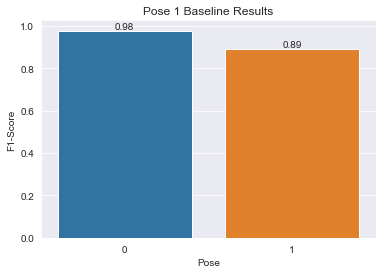

In [287]:
lr = LogisticRegression(class_weight=class_weights, random_state=SEED, max_iter=1000, solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_pred, y_test, title=f'Pose {key_pose} Baseline Results')

In [272]:
# Set params to grid search for ExtraTreesClassifier with Libertard in Testing
params = {
        'n_estimators': [50, 100, 150],
        'max_depth': [14, 16, 18],
        'max_features': ['sqrt', 'log2'],
        'min_samples_split': [2, 4, 6, 8],
        }

best_score = 0
best_grid = None
i = 0
et = ExtraTreesClassifier(random_state=SEED)
for g in ParameterGrid(params):
    i += 1
    et.set_params(**g)
    et.fit(X_train, y_train, sample_weight=weights_array)
    y_pred = et.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(i, f1, g)
    if f1 > best_score:
        best_score = f1
        best_grid = g

1 0.8368336025848142 {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}
2 0.8695652173913044 {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
3 0.8762214983713356 {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 150}
4 0.8654781199351701 {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 50}
5 0.8906752411575563 {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 100}
6 0.8903225806451612 {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 150}
7 0.8644338118022328 {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 50}
8 0.8626817447495961 {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 100}
9 0.8660130718954249 {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 150}
10 0.8730158730158729 {'max_dep

In [273]:
print(best_grid)
print(best_score)

{'max_depth': 16, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 50}
0.8951747088186356


F1 score: 0.8951747088186356
Accuracy score: 0.9653655854865311


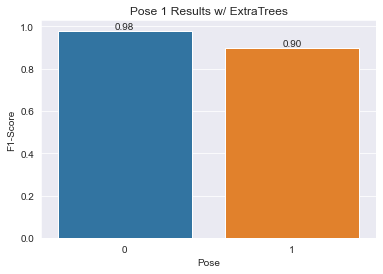

In [288]:
et1 = ExtraTreesClassifier(random_state=SEED)
et1.set_params(**best_grid)
et1.fit(X_train, y_train, sample_weight=weights_array)
y_pred = et1.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
plot_class_f1s(y_test, y_pred, title=f'Pose {key_pose} Results w/ ExtraTrees')